In [1]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
#* 几种QTL条件的基因的Bias score差异
plotData <- data.frame(
    genePair = c(),
    eGene = c(),
    QTLType = c(),
    topVariant = c(),
    QTLid = c(),
    BiasQTLType = c(),
    Biaseffect = c()
)
for (stage in c("0DPA", "4DPA", "8DPA", "12DPA", "16DPA", "20DPA")) {
    data <- read.table(
        paste("filterBias_Gene/", stage, "BiasQTL_V2.txt", sep = ""),
        header = T
    )
    plotData <- rbind(plotData, data)
}
plotData %>% count(BiasQTLType)
plotData$BiasQTLType <- factor(plotData$BiasQTLType,
    levels = c("Bias_eQTL", "onlyBias", "eQTL")
)

BiasQTLType,n
<fct>,<int>
Bias_eQTL,8006
eQTL,23463
onlyBias,9739


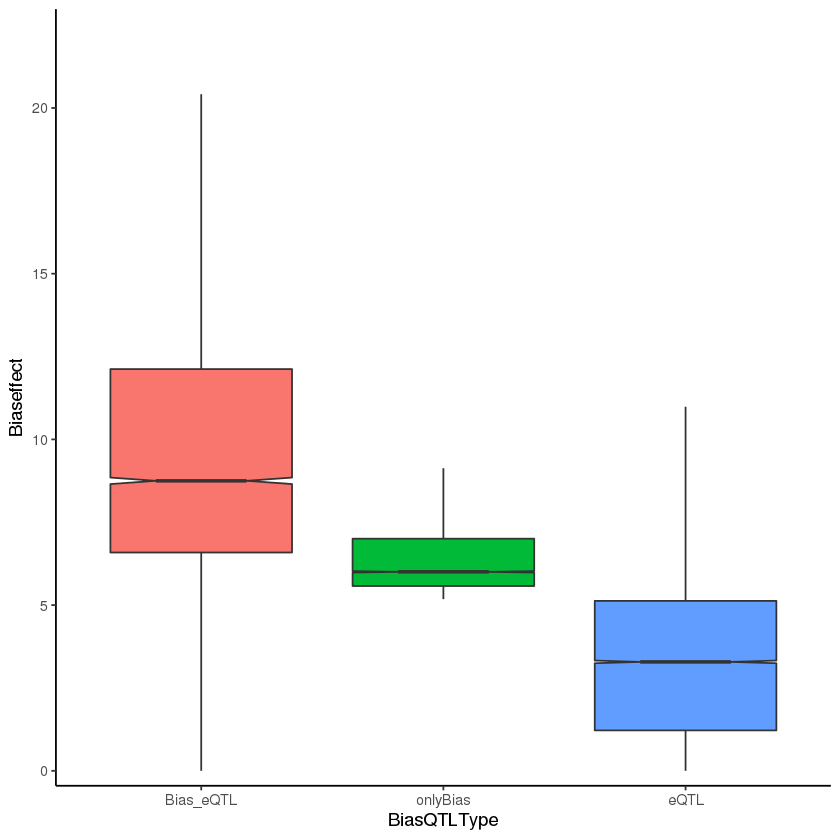

In [5]:
p <- plotData %>%
    ggplot(aes(x = BiasQTLType, y = Biaseffect, fill = BiasQTLType)) +
    geom_boxplot(
        notch = T,
        width = 0.75,
        notchwidth = 0.5,
        outlier.colour = NA
    ) +
    theme_classic() +
    theme(
        legend.position = "none"
    ) +
    scale_y_continuous(expand = c(0.02, 0))
print(p)

In [12]:
#---------------------------------------------
#* 为什么有的基因对能够鉴定到显著性的Bias-QTL；
# ! 而有的同源基因对没有显著性的调控位点,
# ? 主要还是表型在群体内有无明显差异，那些鉴定到显著QTL
# ! 是否受到表达量的影响，比较鉴定到显著位点的这些基因对；
# ! 它们在平均表达水平上有无明显的差异；高表达的基因中更容易检测到Bias-QTL？
#---------------------------------------------
plotData <- data.frame(
    genePair = c(),
    BiasRatio = c(),
    BiasNRatio = c(),
    QTLType = c(),
    GeneCoV = c(),
    At_mean = c(),
    Dt_mean = c(),
    AtContribution = c(),
    MostContribution = c(),
    At_cov = c(),
    Dt_cov = c()
)
for (stage in c("0DPA", "4DPA", "8DPA", "12DPA", "16DPA", "20DPA")) {
    data <- read.table(
        paste("Bias_level/", stage, "_Bias_GeneLevel_multipleTest.txt", sep = ""),
        header = T
    )
    plotData <- rbind(plotData, data)
}
plotData <- plotData %>% mutate(CoV2 = GeneCoV * GeneCoV)

In [13]:
#------------------------------------
# ! 有些同源基因对虽然鉴定到了QTL；
# ! 但是它们自始至终都是在很多个体中Bias
#------------------------------------
OtherGene <- plotData %>%
    filter(QTLType != "nonQTL") %>%
    filter(
        BiasRatio > 0.95 & BiasNRatio < 0.05
    ) %>%
    mutate(QTLType = "Other")
filterGene <- plotData %>%
    filter(!(QTLType != "nonQTL" & BiasRatio > 0.95 & BiasNRatio < 0.05))

plotData <- rbind(filterGene, OtherGene)

In [14]:
head(plotData)

,genePair,BiasRatio,BiasNRatio,QTLType,GeneCoV,At_mean,Dt_mean,AtContribution,MostContribution,At_Cov,Dt_Cov,CoV2
,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Ghir_A01G000130-Ghir_D01G000150,0.9972973,0.000000000,nonQTL,-0.1044364,29.216974,81.272398,0.2632486,0.7367514,0.2293027,0.1765142,0.01090697
2,Ghir_A01G000180-Ghir_D01G000190,0.6243243,0.018918919,nonQTL,-0.2125406,0.825703,3.130121,0.2096270,0.7903730,0.3789606,0.2968577,0.04517352
3,Ghir_A01G000380-Ghir_D01G000380,0.6405405,0.356756757,nonQTL,-0.3054023,2.626356,5.705951,0.3151297,0.6848703,0.2608636,0.2109352,0.09327055
4,Ghir_A01G000540-Ghir_D01G000520,0.5405405,0.267567568,nonQTL,0.3767942,11.301429,5.695970,0.7004081,0.7006568,2.8583524,3.3424379,0.14197387
5,Ghir_A01G000740-Ghir_D01G000710,0.1783784,0.767567568,Bias_eQTL,-1.6744070,2.291132,3.072162,0.3935568,0.6430649,0.5491373,0.2477634,2.80363870
6,Ghir_A01G000880-Ghir_D01G000830,0.3756757,0.005405405,only_one,-0.1561816,32.170896,61.556259,0.3434405,0.6565595,0.3420031,0.3331045,0.02439270


In [15]:
plotData %>%
    # filter(!(QTLType == "Bias_eQTL" & BiasNRatio < 0.05 & BiasRatio > 0.95)) %>%
    filter(!(QTLType == "Other")) %>% count(QTLType)

QTLType,n
<fct>,<int>
Bias_eQTL,5350
nonQTL,17802
only_one,8841


Warning message:
“Removed 2106 rows containing non-finite values (`stat_density()`).”


png 
  2

Warning message:
“Removed 2106 rows containing non-finite values (`stat_density()`).”


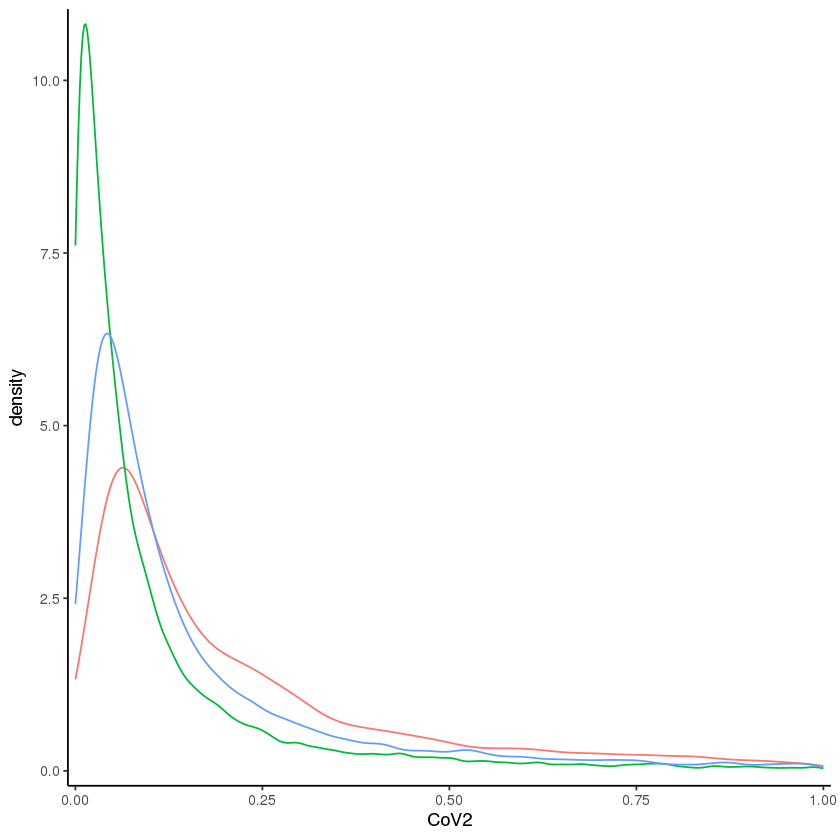

In [16]:
p <- plotData %>%
    # filter(!(QTLType == "Bias_eQTL" & BiasNRatio < 0.05 & BiasRatio > 0.95)) %>%
    filter(!(QTLType == "Other")) %>%
    ggplot(aes(x = CoV2, color = QTLType)) +
    geom_density() +
    scale_x_continuous(limits = c(0, 1), expand = c(0.01, 0)) +
    scale_y_continuous(expand = c(0.02, 0)) +
    theme_classic() +
    theme(
        legend.position = "none"
    )
pdf("Bias_level/Gene_BiasScore_CV2_multipleTest.pdf")
print(p)
dev.off()
p

In [6]:
#--------------------------------------
#* 对不同类型的基因对的Bias 离散度进行非参数检验
#---------------------------------------
A <- plotData %>%
    # filter(!(QTLType == "Bias_eQTL" & BiasNRatio < 0.05 & BiasRatio > 0.95)) %>%
    filter(!(QTLType == "Bias_eQTL")) %>% select("CoV2")
B <- plotData %>%
    # filter(!(QTLType == "Bias_eQTL" & BiasNRatio < 0.05 & BiasRatio > 0.95)) %>%
    filter(!(QTLType == "nonQTL")) %>% select("CoV2")
wilcox.test(
    A$CoV2,
    B$CoV2
)


	Wilcoxon rank sum test with continuity correction

data:  A$CoV2 and B$CoV2
W = 266037624, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


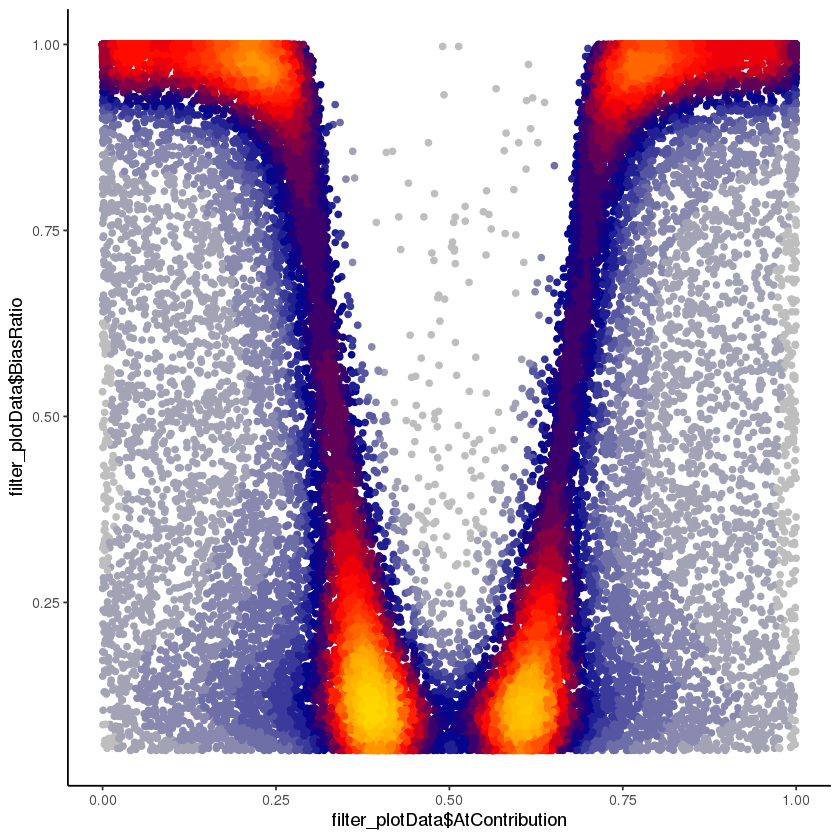

In [12]:
#---------------------------------------------------------------------
# ! 群体水平的Bias有QTL调控的基因对必要因素，取决于个体间Bias水平的差异
#* 我们也发现大多数基因对的Bias呈现两极分化
#---------------------------------------------------------------------
library(LSD)
filter_plotData <- plotData
# filter( QTLType == "Other")
# %>% filter(
#     !(QTLType == "Bias_eQTL" & BiasNRatio < 0.05 & BiasRatio > 0.9))
gg <- heatscatter(
    x = filter_plotData$AtContribution,
    y = filter_plotData$BiasRatio,
    color.contour = "green",
    colpal = "heat", #* 修改热力图颜色显示
    ggplot = TRUE
)

In [15]:
p <- gg +
    scale_x_continuous(expand = c(0.01, 0)) +
    scale_y_continuous(expand = c(0.01, 0))
svg("Bias_level/Gene_BiasRatio_At_Contribution.svg")
print(p)
dev.off()

png 
  2

In [2]:
#--------------------------------------------------------
# TODO 同源基因对的Bias是哪个亚组的变异导致的
#* At亚组上鉴定到QTL的基因对
#* Dt亚组上鉴定到QTL的基因对
# ! 只在某个亚组上鉴定到QTL调控，只是其中一个亚组存在表达变异
#--------------------------------------------------------
library(tidyr)
plotData <- data.frame(
    GenePair = c(),
    At_regulation = c(),
    Dt_regulation = c(),
    BiasRatio = c(),
    BiasNRatio = c(),
    QTLType = c(),
    GeneCoV = c(),
    At_mean = c(),
    Dt_mean = c(),
    AtContribution = c(),
    MostContribution = c(),
    At_cov = c(),
    Dt_cov = c()
)
for (stage in c("0DPA", "4DPA", "8DPA", "12DPA", "16DPA", "20DPA")) {
    data <- read.table(
        paste("Bias_regulation_subgeome/", stage, "_regulation_multiTest.txt", sep = ""),
        header = T
    )
    plotData <- rbind(plotData, data)
}

In [29]:
#! 只有At亚组鉴定到显著的QTL
plotData %>%
    filter(QTLType == "Bias_eQTL" & At_regulation != 0 & Dt_regulation == 0) %>%
    dim()

# ! 只有Dt亚组鉴定到显著的QTL
plotData %>%
    filter(QTLType == "Bias_eQTL" & At_regulation == 0 & Dt_regulation != 0) %>%
    dim()

#* 两个亚组都鉴定到显著的QTL
plotData %>%
    filter(QTLType == "Bias_eQTL" & At_regulation != 0 & Dt_regulation != 0) %>%
    dim()

[1] 2456   13

[1] 2390   13

[1] 504  13

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
Warning message:
“Removed 216 rows containing non-finite values (`stat_density2d()`).”
Warning message:
“Removed 396 rows containing missing values (`geom_raster()`).”


png 
  2

Warning message:
“Removed 216 rows containing non-finite values (`stat_density2d()`).”
Warning message:
“Removed 396 rows containing missing values (`geom_raster()`).”


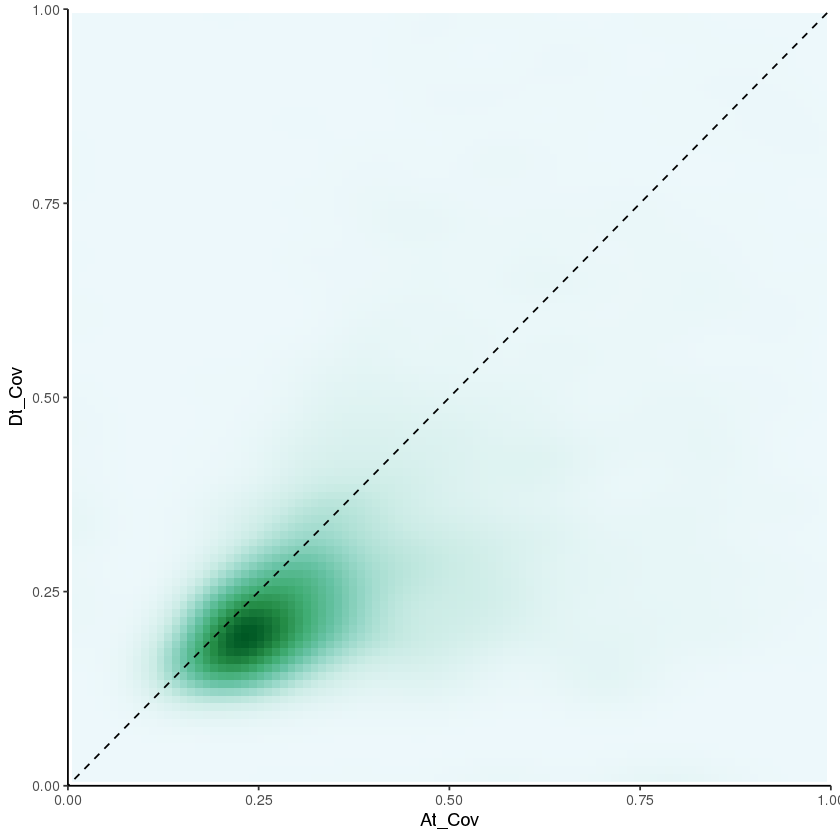

In [19]:
p <- plotData %>%
    filter(QTLType == "Bias_eQTL" & At_regulation != 0 & Dt_regulation == 0) %>%
    ggplot(
        aes(x = At_Cov, y = Dt_Cov)
    ) +
    stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE) +
    scale_fill_distiller(palette = 2, direction = 1) +
    geom_abline(
        slope = 1,
        linetype = "dashed"
    ) +
    scale_x_continuous(limits = c(0, 1), expand = c(0, 0)) +
    scale_y_continuous(limits = c(0, 1), expand = c(0, 0)) +
    theme_classic() +
    theme(legend.position = "none")
pdf("./Bias_regulation_subgeome/At_regulation_multipleTest.pdf")
print(p)
dev.off()
p

In [115]:
#------------------------------------------------
testData <- plotData %>%
    filter(QTLType == "Bias_eQTL" & At_regulation == 0 & Dt_regulation != 0 & At_Cov <= 1 & Dt_Cov <= 1)

Warning message:
“Removed 167 rows containing non-finite values (`stat_density2d()`).”
Warning message:
“Removed 396 rows containing missing values (`geom_raster()`).”


png 
  2

Warning message:
“Removed 167 rows containing non-finite values (`stat_density2d()`).”
Warning message:
“Removed 396 rows containing missing values (`geom_raster()`).”


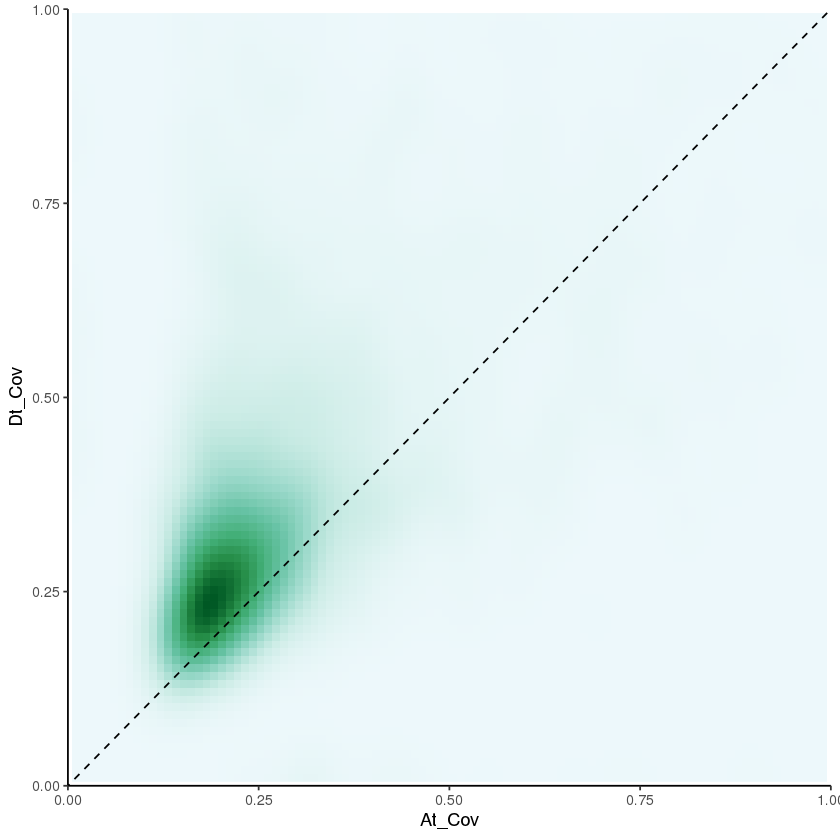

In [21]:
p <- plotData %>%
    filter(QTLType == "Bias_eQTL" & At_regulation == 0 & Dt_regulation != 0) %>%
    ggplot(
        aes(x = At_Cov, y = Dt_Cov)
    ) +
    stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE) +
    scale_fill_distiller(palette = 2, direction = 1) +
    geom_abline(
        slope = 1,
        linetype = "dashed"
    ) +
    scale_x_continuous(limits = c(0, 1), expand = c(0.0, 0)) +
    scale_y_continuous(limits = c(0, 1), expand = c(0.0, 0)) +
    theme_classic() +
    theme(legend.position = "none")
pdf("./Bias_regulation_subgeome/Dt_regulation_multiple.pdf")
print(p)
dev.off()
p

Warning message:
“Removed 40 rows containing non-finite values (`stat_density2d()`).”
Warning message:
“Removed 396 rows containing missing values (`geom_raster()`).”


png 
  2

Warning message:
“Removed 40 rows containing non-finite values (`stat_density2d()`).”
Warning message:
“Removed 396 rows containing missing values (`geom_raster()`).”


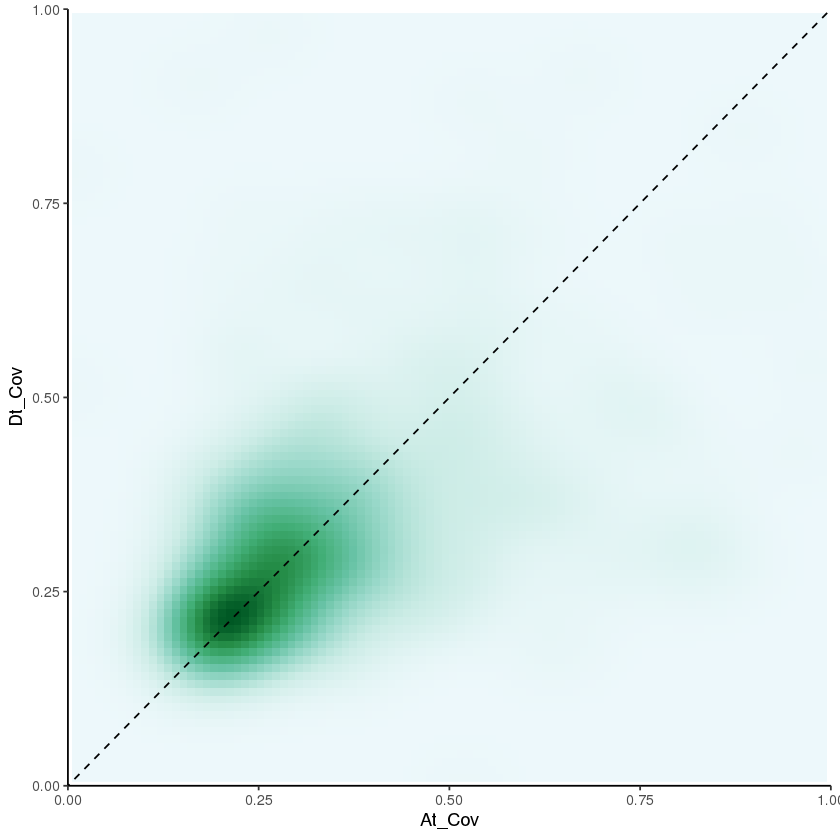

In [22]:
#-----------------------------------------
#* 两个亚组都鉴定到显著的eQTL调控
#-----------------------------------------
p <- plotData %>%
    filter(QTLType == "Bias_eQTL" & At_regulation != 0 & Dt_regulation != 0) %>%
    ggplot(
        aes(x = At_Cov, y = Dt_Cov)
    ) +
    stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE) +
    scale_fill_distiller(palette = 2, direction = 1) +
    geom_abline(
        slope = 1,
        linetype = "dashed"
    ) +
    scale_x_continuous(limits = c(0, 1), expand = c(0.0, 0)) +
    scale_y_continuous(limits = c(0, 1), expand = c(0.0, 0)) +
    theme_classic() +
    theme(legend.position = "none")
pdf("./Bias_regulation_subgeome/All_regulation_multipleTest.pdf")
print(p)
dev.off()
p

In [ ]:
#-------------------------------------------------------------
#* 随机挑选的BiasN 基因对，它在两个亚组中基因表达变异系数
#-------------------------------------------------------------

In [6]:
#-------------------------------------------------------
#* 分析这些基因对在cis调控区域SNP的数目
#-------------------------------------------------------
getSNPData <- function(stage) {
    #* BiasGene
    BiasGene <- read.table(
        paste("Bias_regulation_subgeome/", stage, "_regulation_multiTest.txt", sep = ""),
        header = T
    )
    At_regulate_Gene <- BiasGene %>% filter(QTLType == "Bias_eQTL" & At_regulation != 0 & Dt_regulation == 0)
    Dt_regulate_Gene <- BiasGene %>% filter(QTLType == "Bias_eQTL" & At_regulation == 0 & Dt_regulation != 0)
    All_regulate_Gene <- BiasGene %>% filter(QTLType == "Bias_eQTL" & At_regulation != 0 & Dt_regulation != 0)
    #* SNP Data
    SNPData <- read.table(
        paste("./Gene_SNPCount/", stage, "_QTL_SNPCounts.txt", sep = ""),
        header = T
    )
    At_regulate_Gene <- SNPData %>% filter(genePair %in% At_regulate_Gene$GenePair)
    At_regulate_Gene$GeneType <- "At_regulate"
    Dt_regulate_Gene <- SNPData %>% filter(genePair %in% Dt_regulate_Gene$GenePair)
    Dt_regulate_Gene$GeneType <- "Dt_regulate"
    All_regulate_Gene <- SNPData %>% filter(genePair %in% All_regulate_Gene$GenePair)
    All_regulate_Gene$GeneType <- "All_regulate"
    BiasNGene <- SNPData %>% filter(GeneType == "BiasN")
    mregeData <- rbind(At_regulate_Gene, Dt_regulate_Gene, All_regulate_Gene, BiasNGene)
    out <- data.frame(
        genePair = c(),
        GeneType = c(),
        Region = c(),
        SNPCount = c(),
        subgenome = c()
    )
    for (geneRegion in c("geneSNPcount", "UPSNPCount", "DownSNPCount")) {
        At_region <- paste("AT", geneRegion, sep = "_")
        Dt_region <- paste("DT", geneRegion, sep = "_")
        tmpData <- mregeData %>%
            select(c("genePair", "GeneType", At_region, Dt_region)) %>%
            pivot_longer(
                cols = c(At_region, Dt_region),
                names_to = "Region",
                values_to = "SNPCount"
            )
        tmpData <- tmpData %>% mutate(subgenome = strsplit(Region, paste("_", geneRegion, sep = "")))
        out <- rbind(out, tmpData)
    }
    return(out)
}
data_0DPA <- getSNPData("0DPA")
data_4DPA <- getSNPData("4DPA")
data_8DPA <- getSNPData("8DPA")
data_12DPA <- getSNPData("12DPA")
data_16DPA <- getSNPData("16DPA")
data_20DPA <- getSNPData("20DPA")
MergeData <- rbind(data_0DPA, data_4DPA, data_8DPA, data_12DPA, data_16DPA, data_20DPA)
MergeData$SNPCount <- as.integer(as.character(MergeData$SNPCount))

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(At_region)

  # Now:
  data %>% select(all_of(At_region))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(Dt_region)

  # Now:
  data %>% select(all_of(Dt_region))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [7]:
getSNPRegion <- function(x) {
    regionType <- gsub("[AD]T_", "", x)
    if (regionType == "geneSNPcount") {
        #* 基因body
        return(2)
    } else if (regionType == "UPSNPCount") {
        #* 基因上游
        return(1)
    } else {
        #* 基因下游
        return(3)
    }
}
MergeData$xaxis <- lapply(MergeData$Region, getSNPRegion)
MergeData$subgenome <- as.character(MergeData$subgenome)
MergeData$xaxis <- as.factor(as.integer(MergeData$xaxis))
head(MergeData)

genePair,GeneType,Region,SNPCount,subgenome,xaxis
<fct>,<chr>,<chr>,<int>,<chr>,<fct>
Ghir_A01G000740-Ghir_D01G000710,At_regulate,AT_geneSNPcount,4,AT,2
Ghir_A01G000740-Ghir_D01G000710,At_regulate,DT_geneSNPcount,3,DT,2
Ghir_A01G001190-Ghir_D01G001190,At_regulate,AT_geneSNPcount,1,AT,2
Ghir_A01G001190-Ghir_D01G001190,At_regulate,DT_geneSNPcount,7,DT,2
Ghir_A01G001580-Ghir_D01G001580,At_regulate,AT_geneSNPcount,11,AT,2
Ghir_A01G001580-Ghir_D01G001580,At_regulate,DT_geneSNPcount,9,DT,2


Warning message:
“Removed 58 rows containing non-finite values (`stat_boxplot()`).”


png 
  2

Warning message:
“Removed 58 rows containing non-finite values (`stat_boxplot()`).”


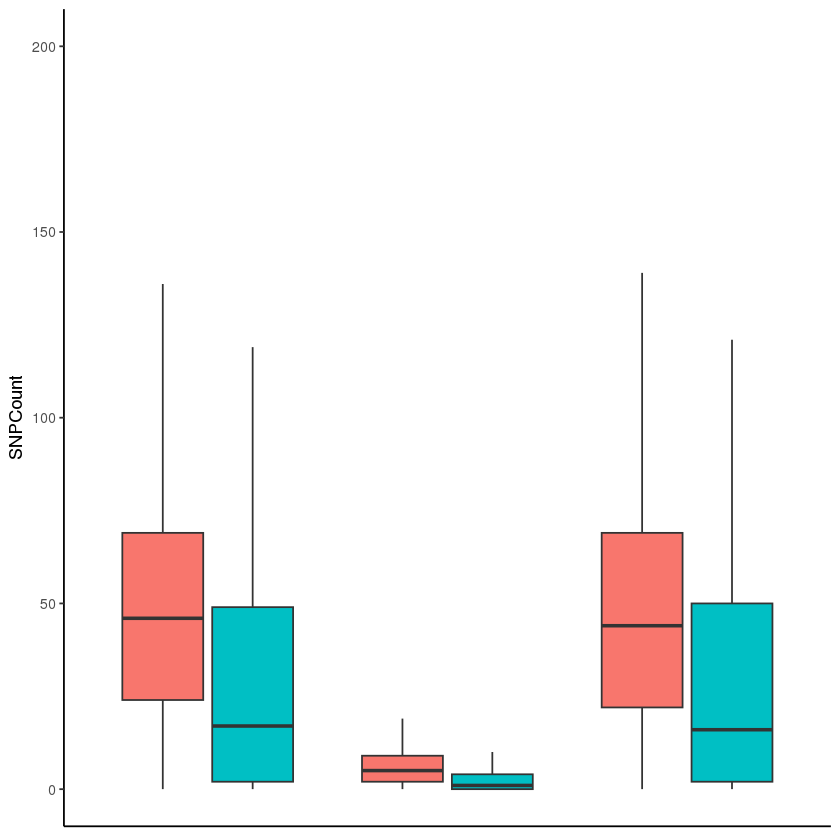

In [25]:
library(ggplot2)
p <- MergeData %>%
    filter(GeneType == "At_regulate") %>%
    ggplot(
        aes(x = xaxis, y = SNPCount, fill = subgenome)
    ) +
    geom_boxplot(
        outlier.colour = NA,
        width = 0.75
    ) +
    theme_classic() +
    theme(
        legend.position = "none",
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank()
    ) +
    scale_y_continuous(limits = c(0, 200))
pdf("./Bias_regulation_subgeome/At_regulation_SNPCount_multipleTest.pdf")
print(p)
dev.off()
p

Warning message:
“Removed 248 rows containing non-finite values (`stat_boxplot()`).”


png 
  2

Warning message:
“Removed 248 rows containing non-finite values (`stat_boxplot()`).”


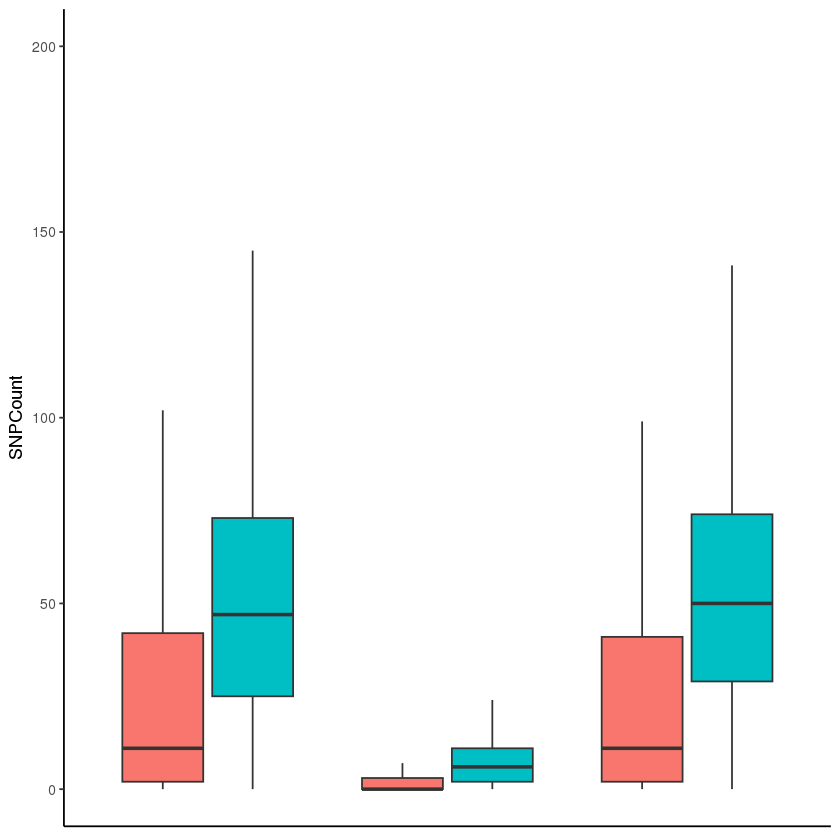

In [26]:
library(ggplot2)
p <- MergeData %>%
    filter(GeneType == "Dt_regulate") %>%
    ggplot(
        aes(x = xaxis, y = SNPCount, fill = subgenome)
    ) +
    geom_boxplot(
        outlier.colour = NA,
        width = 0.75
    ) +
    theme_classic() +
    theme(
        legend.position = "none",
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank()
    ) +
    scale_y_continuous(limits = c(0, 200))
pdf("./Bias_regulation_subgeome/Dt_regulation_SNPCount_multipleTest.pdf")
print(p)
dev.off()
p

Warning message:
“Removed 239 rows containing non-finite values (`stat_boxplot()`).”


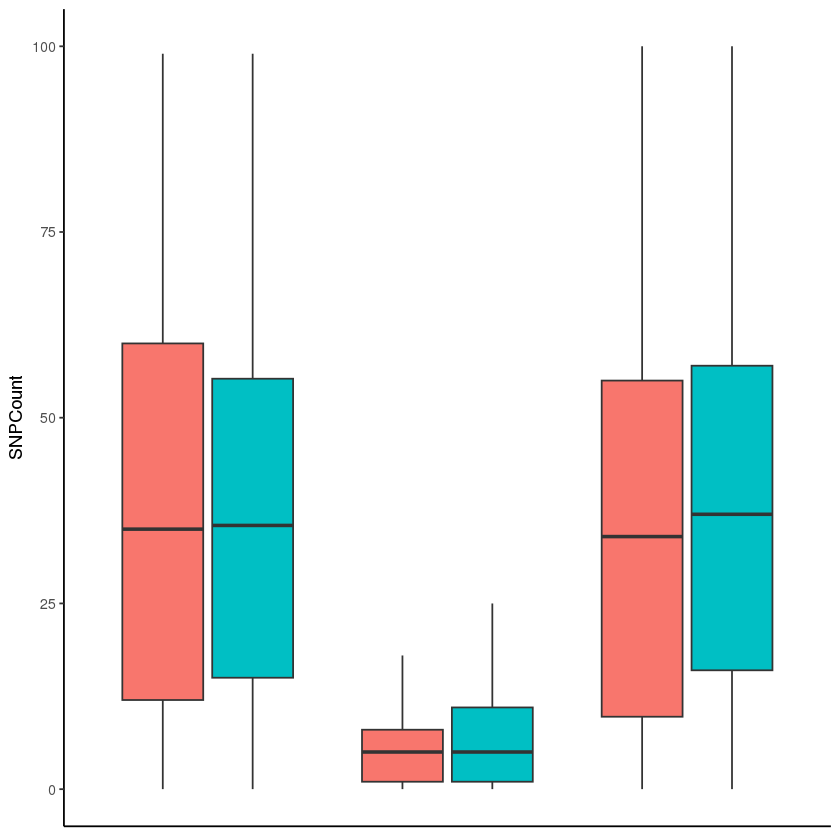

In [15]:
library(ggplot2)
p <- MergeData %>%
    filter(GeneType == "All_regulate") %>%
    ggplot(
        aes(x = xaxis, y = SNPCount, fill = subgenome)
    ) +
    geom_boxplot(
        outlier.colour = NA,
        width = 0.75
    ) +
    theme_classic() +
    theme(
        legend.position = "none",
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank()
    ) +
    scale_y_continuous(limits = c(0, 100))
pdf("./Bias_regulation_subgeome/BiasN_SNPCount_multipleTest.pdf")
print(p)
dev.off()
p

In [34]:
a=MergeData %>%
    filter(GeneType == "All_regulate") %>% filter(Region=="AT_geneSNPcount") %>% pull(SNPCount)
b=MergeData %>%
    filter(GeneType == "All_regulate") %>% filter(Region=="AT_geneSNPcount") %>% pull(SNPCount)

wilcox.test(a,b)


	Wilcoxon rank sum test with continuity correction

data:  a and b
W = 127008, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  a and b
W = 108180, p-value = 4.614e-05
alternative hypothesis: true location shift is not equal to 0


Region,n
<chr>,<int>
AT_DownSNPCount,504
AT_UPSNPCount,504
AT_geneSNPcount,504
DT_DownSNPCount,504
DT_UPSNPCount,504
DT_geneSNPcount,504
